# Table of Content

Target: Predict users at risk to churn either downgrade from premium to free tier or cancelling their services altogether.

1. Load and Clean Dataset
2. Exploratory Data Analysis.
3. Feature Engineering.
4. Model Training and Prediction.

#### Import Libraries

In [1]:
# Import libraries
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession

from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import avg, stddev, isnan, split, udf, isnull, first, col, format_number, rand, countDistinct,count, trim, desc, countDistinct, expr, min, max
from pyspark.sql.functions import min as fmin
from pyspark.sql.functions import max as fmax
from pyspark.sql.functions import sum as fsum
from pyspark.sql.types import IntegerType, FloatType, StringType

import pyspark.sql.functions as f

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier,RandomForestClassifier, LinearSVC, GBTClassifier
from pyspark.ml.feature import StringIndexer, OneHotEncoder, StandardScaler, VectorAssembler, Normalizer, MinMaxScaler, VectorAssembler, HashingTF
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import re
import copy
import time
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#### Create a SparkSession for using spark and name it "SwaNam Mlops".

In [2]:
# Create a Spark session
spark = SparkSession \
    .builder \
    .appName('SwanNam Mlops') \
    .getOrCreate()

# Load and Clean Dataset
The following steps will be processed with subset of a 12GB dataset named `music_churn.json`. First of all the dataset the dataset will be loaded, cleaned and checked for invalid or missing data.

In [3]:
# Read json data
music_churn = 'music_churn.json'
df = spark.read.json(music_churn)

In [4]:
# Show all columns and data types
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
# Select and show statistcs for several items
for col in df.schema:
    if str(col.name) in ['artist','auth','gender','level' ,'location','page']:
        df.groupBy(str(col.name)).count().show() # Understand the meaning of columns

+--------------------+-----+
|              artist|count|
+--------------------+-----+
|      The Black Keys|  945|
|         Silverstein|   49|
|           Kate Nash|   80|
|        Yann Tiersen|  109|
|    Jane's Addiction|   63|
|          Tim Hughes|   35|
|          Carl Craig|    3|
|Dashboard Confess...|   83|
|Yonder Mountain S...|   50|
|           Los Lobos|   34|
|Pete Rock & C.L. ...|    2|
|        Ziggy Marley|   22|
|      Jarabe De Palo|   68|
|               Rufio|   11|
|WC And The Maad C...|    1|
|      Jorge Gonzalez|   19|
|                Silk|   19|
|  The Watts Prophets|    5|
|            La Shica|    2|
|        Generation X|   16|
+--------------------+-----+
only showing top 20 rows

+----------+------+
|      auth| count|
+----------+------+
|Logged Out|  7082|
| Cancelled|    46|
|     Guest|    97|
| Logged In|233666|
+----------+------+

+------+------+
|gender| count|
+------+------+
|     F|124445|
|  NULL|  7179|
|     M|109267|
+------+------+

+---

In [6]:
# Check for null values
for i in df.columns:
    print(i, ':', df.filter(df[i].isNull()).count())

artist : 48794
auth : 0
firstName : 7179
gender : 7179
itemInSession : 0
lastName : 7179
length : 48794
level : 0
location : 7179
method : 0
page : 0
registration : 7179
sessionId : 0
song : 48794
status : 0
ts : 0
userAgent : 7179
userId : 0


In [7]:
# Total sessions after removing duplicates based on user and session id
df = df.dropna(how = "any", subset = ["userId", "sessionId"])
df.count()

240891

In [8]:
# Total number of sessions after removing blank user id
df = df.filter(df["userId"] != "")
df.count()

233712

In [9]:
# Number of unique users in dataset
user_ids = df.select('userId').dropDuplicates().count()
print('The number of unique users in dataset: ' + str(user_ids))

# Number of unique session ids
session_ids = df.select('sessionId').dropDuplicates().count()
print('The number of unique session ids: ' + str(session_ids))

# Number of unique pages
pages = df.select('page').dropDuplicates().count()
print('The number of unique pages: ' + str(pages))

The number of unique users in dataset: 199
The number of unique session ids: 2299
The number of unique pages: 19


# Exploratory Data Analysis (EDA)
“Churn” label is generated from the dataset by identifying users who confirm their subscription cancellation. Once churned users are identified, we can view how it behaves with other features in the dataset. We will be exploring the data to see trends and features that may influence the churn rate.

### Define Churn
- Create a churn label column for the dataset. It returns 1 if Cancellation Confirmation events happens

In [10]:
# Churn Definition
churn_def = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
# Apply to the dataframe
df = df.withColumn("churn", churn_def("page"))
# Define window bounds
windowval = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
# Applying the window
df = df.withColumn("churn", fsum("churn").over(windowval))

### Distribution of Users by Churn Type
- There are 225 total users, 52 users were identified to be churned; this is approxiately 24% of the universe.

In [11]:
# Distribution of users by Churn Type
churn_count = df.groupBy("Churn").agg(countDistinct("userId").alias("Users"))
churn_count_pd = churn_count.toPandas() # Create churn count dataframe
churn_count.show()

+-----+-----+
|Churn|Users|
+-----+-----+
|    0|  153|
|    1|   46|
+-----+-----+



Text(0, 0.5, 'Number of Users')

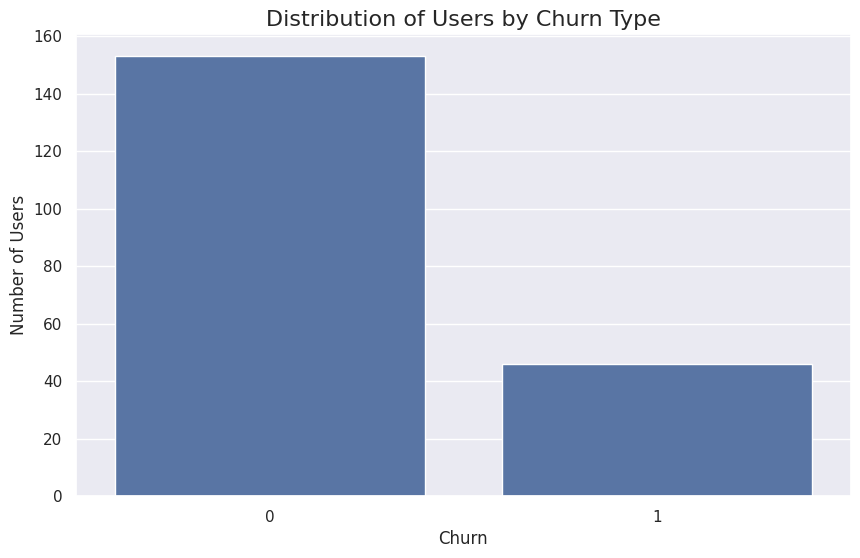

In [12]:
# Distribution of users by Churn Type Plot
sns.set_theme(style="darkgrid")
plt.figure(figsize=(10, 6))
plt.title("Distribution of Users by Churn Type", fontsize= 16)
sns.barplot(x='Churn', y='Users', data= churn_count_pd)
plt.xlabel("Churn")
plt.ylabel("Number of Users")

### Churn per Gender
- We have more male users (~54% male, ~46% female) in our dataset so it’s no surprise that we’d have more male users who churn. The churn rate for males is quite higher than females (26% vs 19%).

In [13]:
# Churn per gender plot
churn_gender_pd = df.filter(df.page == 'Cancellation Confirmation').select(['userId', 'gender']).drop_duplicates().groupby('gender').count().toPandas()
churn_gender_pd['Churn'] = True
nonchurn_gender_pd = df.filter(df.page != 'Cancellation Confirmation').select(['userId', 'gender']).drop_duplicates().groupby('gender').count().toPandas()
nonchurn_gender_pd['Churn'] = False
churn_gender = pd.concat([churn_gender_pd, nonchurn_gender_pd], sort=False, ignore_index=True)
churn_gender.head()

,gender,count,Churn
0,F,18,True
1,M,28,True
2,F,92,False
3,M,107,False


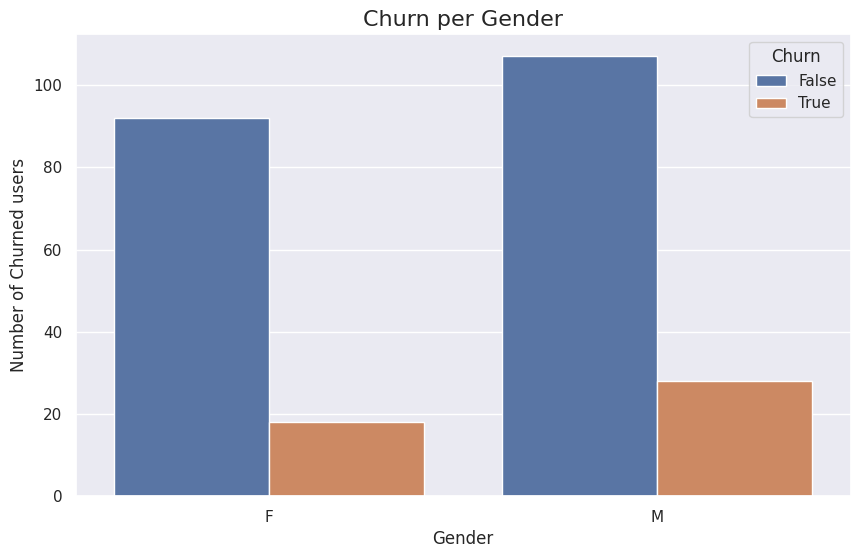

In [14]:
# Plot churn per gender
plt.figure(figsize=(10, 6))
plt.title('Churn per Gender', fontsize=16)
sns.barplot(x='gender', y='count', hue='Churn', data=churn_gender)
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Number of Churned users', fontsize=12)
plt.show()

In [15]:
# Create a temporary view to perform SQL operations
df.createOrReplaceTempView("df_sqlmusic")

In [16]:
# Create DataFrame for total user in location
location_df = spark.sql("""
                           SELECT location,
                                  Count(DISTINCT userid) AS total_user
                           FROM   df_sqlmusic
                           GROUP  BY location
                           ORDER BY total_user
                           DESC
                           """).toPandas()

In [17]:
# Create DataFrame for churn user in location
location_churn_df = spark.sql("""
                                 SELECT location,
                                        Count(DISTINCT userid) AS churn_user
                                 FROM   df_sqlmusic
                                 WHERE  churn=1
                                 GROUP BY location
                                 """).toPandas()

In [18]:
# Merge DataFrame and add percentage column
merge_df = location_churn_df.merge(location_df, on="location").sort_values(by="total_user", ascending=False)
merge_df["percentage"] = merge_df["churn_user"] / merge_df["total_user"] * 100
merge_df.sort_values(by="percentage", ascending=False).head(20)

,location,churn_user,total_user,percentage
34,"Flint, MI",2,2,100.0
25,"North Wilkesboro, NC",1,1,100.0
2,"Corpus Christi, TX",1,1,100.0
4,"Albany, OR",1,1,100.0
9,"Selma, AL",1,1,100.0
11,"New Philadelphia-Dover, OH",1,1,100.0
15,"Oxnard-Thousand Oaks-Ventura, CA",1,1,100.0
16,"Memphis, TN-MS-AR",1,1,100.0
1,"Birmingham-Hoover, AL",1,1,100.0
19,"Little Rock-North Little Rock-Conway, AR",1,1,100.0


### Churn vs Total User in Location
- The locations with the highest total users and churn users are in ‘Los Angelos-Long Beach-Anaheim, CA’, ‘New York-Newark-Jersey City, NY-NJ-PA’, and ‘Phoenix-Mesa-Scottsdale, AZ’. User locations are scattered widely and are rather sparse in almost all locations.

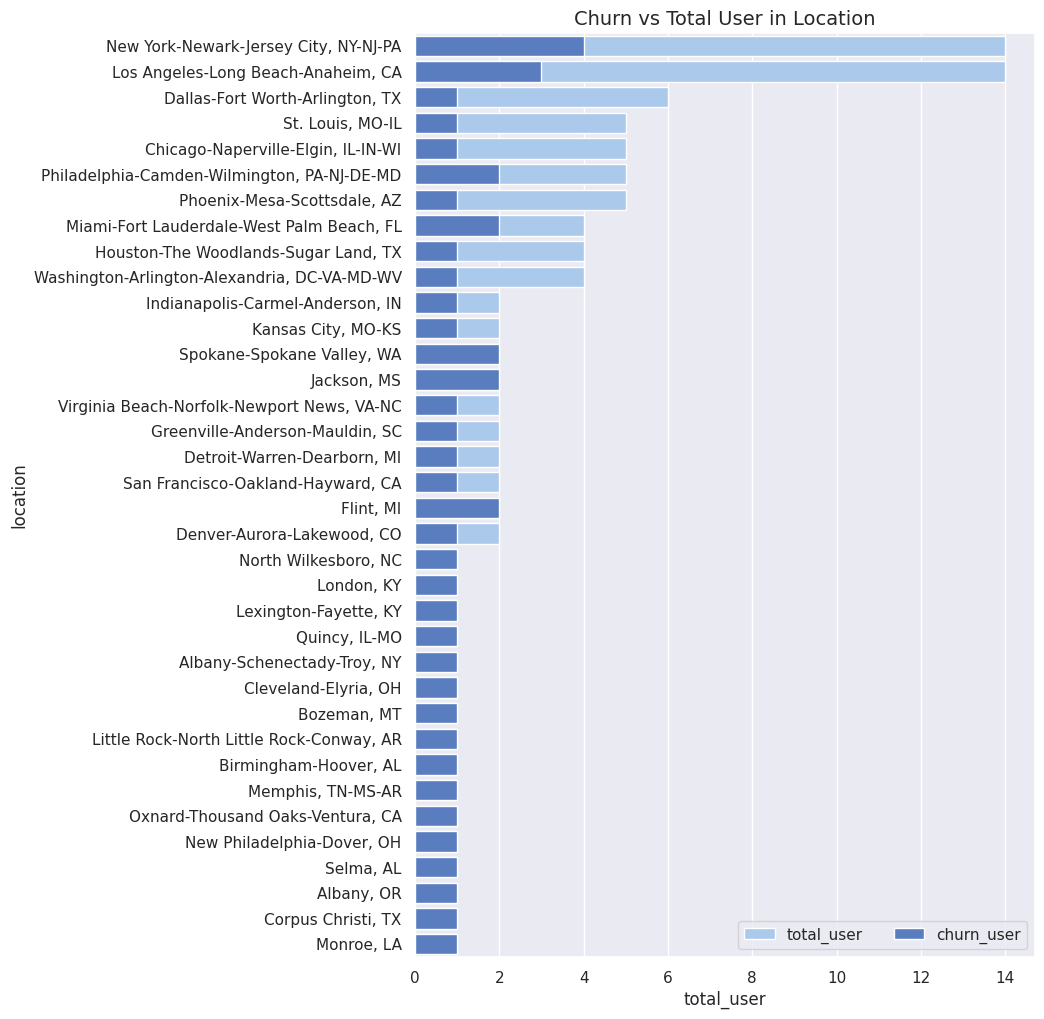

In [19]:
fig, ax = plt.subplots(figsize=(8, 12))
plt.title("Churn vs Total User in Location", fontsize=14)
sns.set_color_codes("pastel")
sns.barplot(x="total_user", y="location", data=merge_df, ax=ax,
            label="total_user",color="b")

sns.set_color_codes("muted")
sns.barplot(x="churn_user", y="location", data=merge_df, ax=ax,
            label="churn_user",color="b")
ax.legend(ncol=2, loc="lower right", frameon=True)

### Churn vs Non-churn User per Device
- We can see that most users use Windows or Mac to access the service, which also have the most customer churn. The churn rate for Windows users is 18.5% which is slightly higher than Mac sitting at 18.1%. Devices such as X11 and iPhone have a much lower user base resulting in lower churn amount.

In [20]:
get_device = udf(lambda x: x.split('(')[1].replace(";", " ").split(" ")[0])
df_devices = df.withColumn('Device', get_device('userAgent'))

print('Churn User per device')
df_devices.filter(df.page == 'Cancellation Confirmation').select(['userId', 'Device']).drop_duplicates().groupby('Device').count().show()

print('Non-churn User per device')
df_devices.filter(df.page != 'Cancellation Confirmation').select(['userId', 'Device']).drop_duplicates().groupby('Device').count().show()

Churn User per device
+---------+-----+
|   Device|count|
+---------+-----+
|      X11|    4|
|   iPhone|    3|
|Macintosh|   16|
|  Windows|   23|
+---------+-----+

Non-churn User per device
+----------+-----+
|    Device|count|
+----------+-----+
|      iPad|    3|
|       X11|    9|
|    iPhone|   11|
| Macintosh|   77|
|compatible|    4|
|   Windows|   95|
+----------+-----+



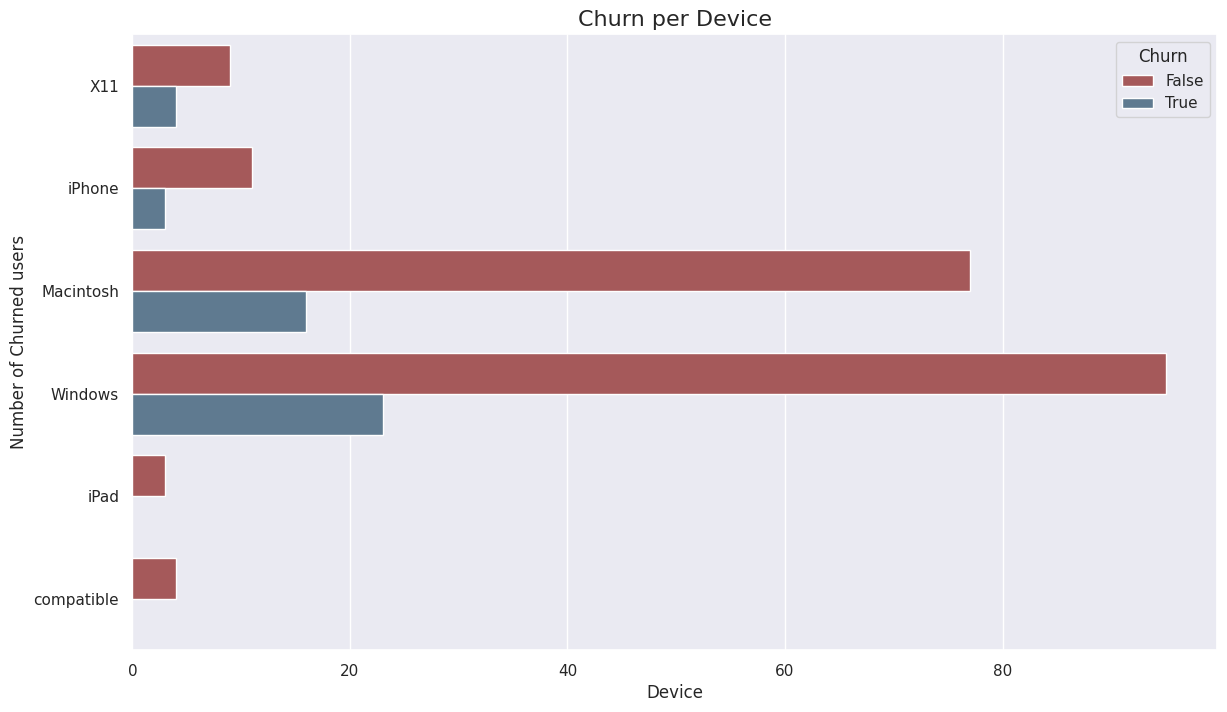

In [21]:
# Churn per device plot
churn_device_pd = df_devices.filter(df_devices.page == 'Cancellation Confirmation').select(['userId', 'Device']).drop_duplicates().groupby('Device').count().toPandas()
churn_device_pd['Churn'] = True
nonchurn_device_pd = df_devices.filter(df_devices.page != 'Cancellation Confirmation').select(['userId', 'Device']).drop_duplicates().groupby('Device').count().toPandas()
nonchurn_device_pd['Churn'] = False
churn_device = pd.concat([churn_device_pd,nonchurn_device_pd], sort=False, ignore_index=True)

# Plot
plt.figure(figsize=(14,8))
sns.set_palette("Set1",n_colors=8, desat=.5)
sns.barplot(x='count', y='Device', hue='Churn', data=churn_device)
plt.xlabel('Device', fontsize=12)
plt.ylabel('Number of Churned users', fontsize=12)
plt.title('Churn per Device', fontsize=16)
plt.show()

### Distribution of Page and Churn Users
- Pages such as ‘Next Song’, ‘Thumbs Up’, ‘Add Friend’, and ‘Add to Playlist’ have a higher proportion of non-churn users. Finding the number of users visit these pages may determine if the users are likely to churn or not.

In [22]:
page_churn_df = spark.sql("""
                    SELECT page,
                           churn,
                           COUNT(DISTINCT(userId)) AS total_user
                    FROM   df_sqlmusic
                    GROUP BY page,
                             churn
                    """).toPandas()

In [23]:
def sns_barplot_text(x, y, data, title, hue=None, percentage=True, text=True,
                     log=False, figsize=(8, 5)):
    """
    Similar to sns.barplot but added text option for the bar
    """
    fig, ax = plt.subplots(figsize=figsize)
    sns.barplot(x=x, y=y, data=data, hue=hue, ax=ax, log=log)
    ax.set_xlabel(f"{data.columns[0]}")
    ax.set_title(title)
    ax.set_xticklabels(data.loc[:,x].unique(), rotation=90)
    if text:
        for p in ax.patches:
                height = p.get_height()
                if percentage:
                    ax.text(p.get_x() + p.get_width() / 2.,
                            height,
                            f"{height /data.loc[:,y].sum() * 100 :.2f}%",
                            ha="center", fontsize=8)
                else:
                    ax.text(p.get_x() + p.get_width() / 2.,
                            height,
                            f"{height :.2f}",
                            ha="center", fontsize=8)

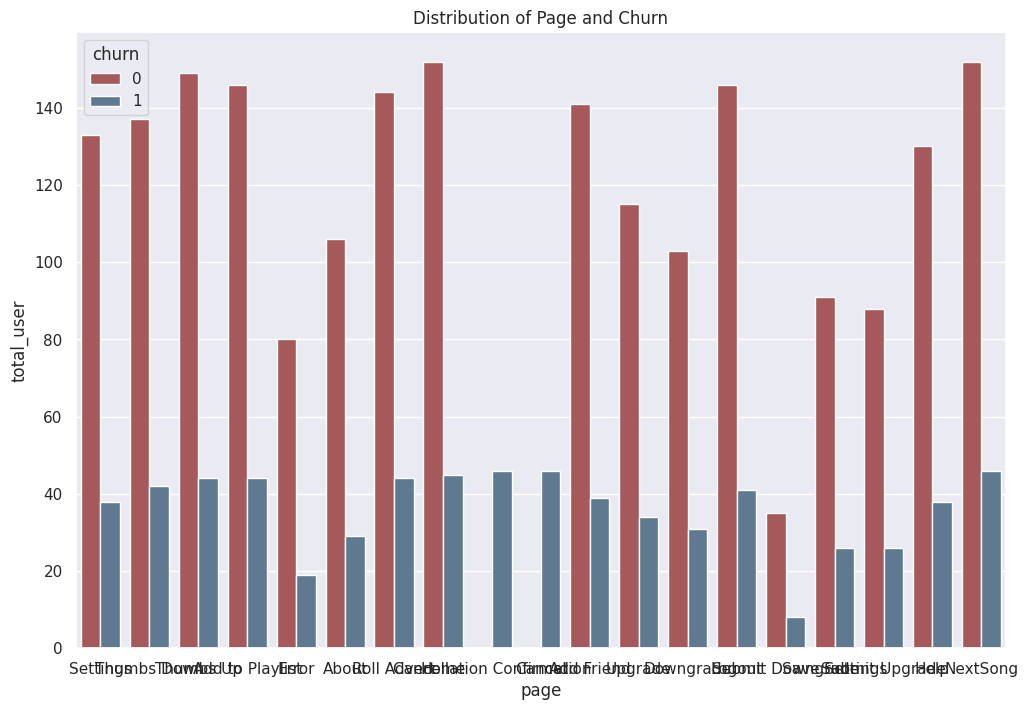

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the bar plot using Seaborn
plt.figure(figsize=(12, 8))
sns.barplot(x="page", y="total_user", data=page_churn_df, hue="churn")

# Add title
plt.title("Distribution of Page and Churn")

# Show the plot
plt.show()


Analyzing Song/Artist Diversity Among Churned vs. Retained Users

Do churned users engage differently with core features?

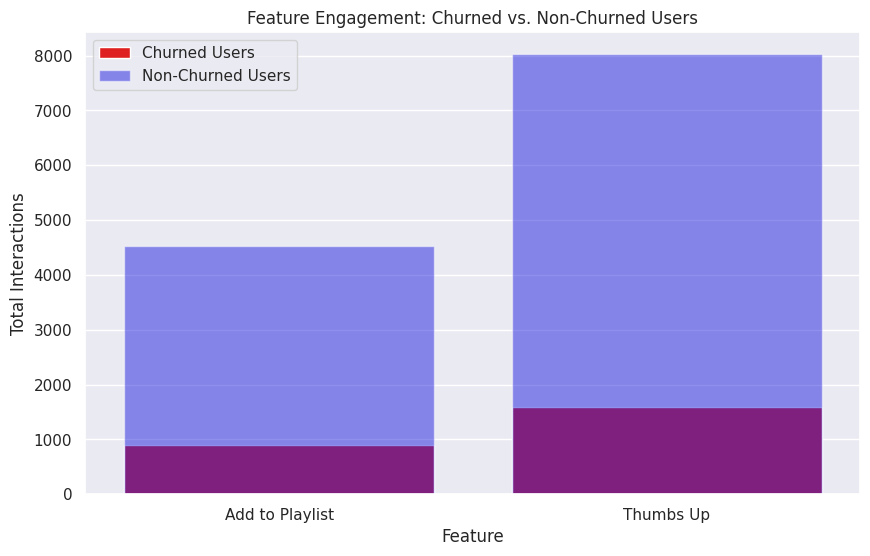

In [25]:
from pyspark.sql.functions import col, countDistinct, avg

# Define key engagement features
engagement_features = ["Thumbs Up", "Add to Playlist", "Next Song"]

# Filter dataset for churned and non-churned users
churned_users = df.filter(df.churn == 1)
non_churned_users = df.filter(df.churn == 0)

# Count interactions per feature for churned users
churned_engagement = churned_users.filter(df.page.isin(engagement_features)) \
    .groupBy("page").agg(countDistinct("userId").alias("Churned Users"), count("page").alias("Total Interactions"))

# Count interactions per feature for non-churned users
non_churned_engagement = non_churned_users.filter(df.page.isin(engagement_features)) \
    .groupBy("page").agg(countDistinct("userId").alias("Non-Churned Users"), count("page").alias("Total Interactions"))

# Convert to Pandas for visualization
churned_df = churned_engagement.toPandas()
non_churned_df = non_churned_engagement.toPandas()

import matplotlib.pyplot as plt
import seaborn as sns

# Merge for comparison
merged_df = churned_df.merge(non_churned_df, on="page", suffixes=("_churned", "_nonchurned"))

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=merged_df, x="page", y="Total Interactions_churned", color='red', label="Churned Users")
sns.barplot(data=merged_df, x="page", y="Total Interactions_nonchurned", color='blue', label="Non-Churned Users", alpha=0.5)
plt.xlabel("Feature")
plt.ylabel("Total Interactions")
plt.title("Feature Engagement: Churned vs. Non-Churned Users")
plt.legend()
plt.show()


Which pages do users visit most frequently before they churn?

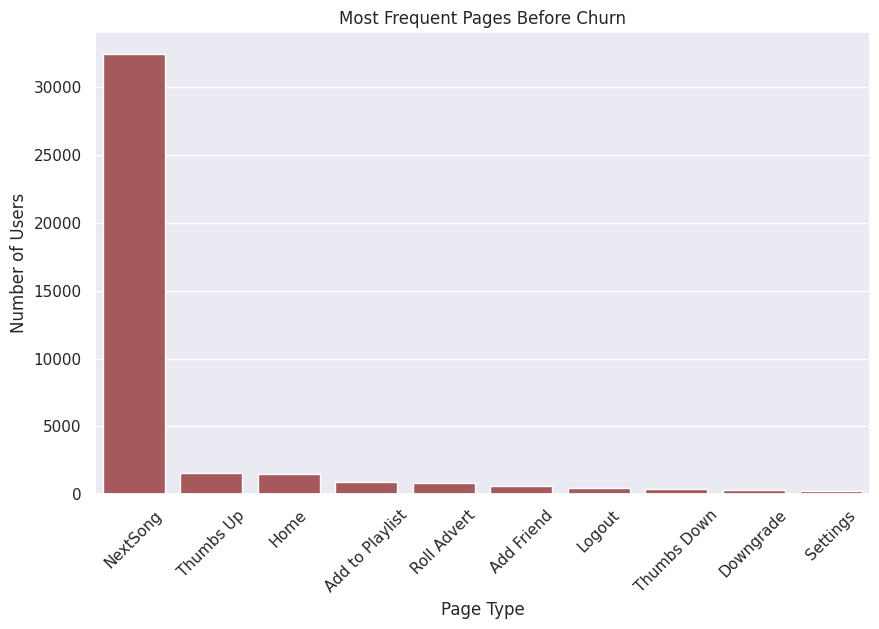

In [26]:
from pyspark.sql.window import Window
from pyspark.sql.functions import lag

# Create a window function to track user actions leading up to churn
window = Window.partitionBy("userId").orderBy("ts")

# Get the last visited page before a user churned
df = df.withColumn("Previous Page", lag("page", 1).over(window))

# Filter only churned users
churned_users_last_pages = df.filter(df.churn == 1).groupBy("Previous Page").count().orderBy(col("count").desc())

# Convert to Pandas for visualization
churned_last_pages_df = churned_users_last_pages.toPandas()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=churned_last_pages_df.head(10), x="Previous Page", y="count")
plt.xlabel("Page Type")
plt.ylabel("Number of Users")
plt.title("Most Frequent Pages Before Churn")
plt.xticks(rotation=45)
plt.show()


Do churned users listen to fewer unique artists compared to non-churned users?

<ipython-input-27-1c3f87fc5c67>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=artist_stats, x="churn", y="avg_unique_artists", palette=["blue", "red"])


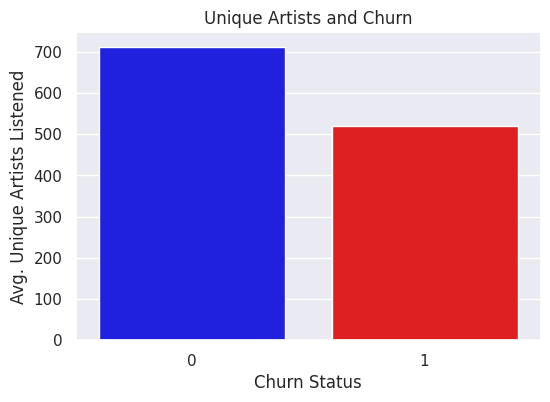

In [27]:
# Count unique artists per user
unique_artists = df.groupBy("userId", "churn") \
    .agg(countDistinct("artist").alias("unique_artists"))

# Compute average unique artists per user for churned vs. non-churned
artist_stats = unique_artists.groupBy("churn").agg(avg("unique_artists").alias("avg_unique_artists")).toPandas()

# Visualization
plt.figure(figsize=(6, 4))
sns.barplot(data=artist_stats, x="churn", y="avg_unique_artists", palette=["blue", "red"])
plt.xlabel("Churn Status")
plt.ylabel("Avg. Unique Artists Listened")
plt.title("Unique Artists and Churn")
plt.show()


Do churned users interact less with social features like "Add Friend" or "Share"?

<ipython-input-28-55ce693fd77c>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=social_stats, x="churn", y="avg_social_interactions", palette=["blue", "red"])


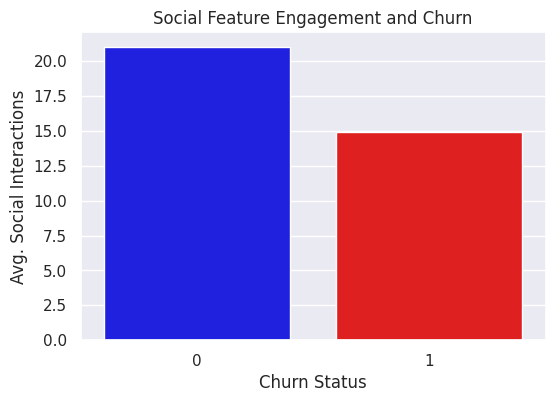

In [28]:
# Define social interaction features
social_features = ["Add Friend", "Share"]

# Count social interactions per user
social_engagement = df.filter(df.page.isin(social_features)) \
    .groupBy("userId", "churn").count()

# Compute average social interactions for churned vs. non-churned users
social_stats = social_engagement.groupBy("churn").agg(avg("count").alias("avg_social_interactions")).toPandas()

# Visualization
plt.figure(figsize=(6, 4))
sns.barplot(data=social_stats, x="churn", y="avg_social_interactions", palette=["blue", "red"])
plt.xlabel("Churn Status")
plt.ylabel("Avg. Social Interactions")
plt.title("Social Feature Engagement and Churn")
plt.show()


Are users with failed payments more likely to churn?

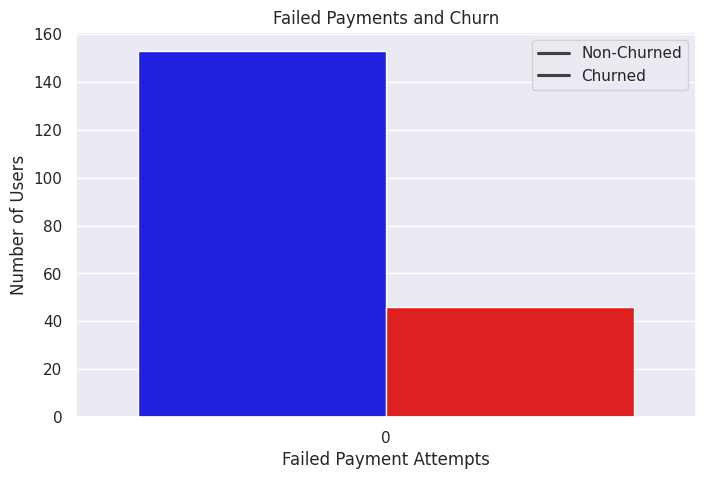

In [29]:
# Identify failed payments
failed_payments = df.filter(df.page == "Submit Payment Failure") \
    .groupBy("userId").count().withColumnRenamed("count", "failed_payment_attempts")

# Merge with churn status
churn_payment_df = df.select("userId", "churn").distinct().join(failed_payments, "userId", "left").fillna(0)

# Compare churn rates for users with and without failed payments
payment_stats = churn_payment_df.groupBy("failed_payment_attempts", "churn").count().toPandas()

# Visualization
plt.figure(figsize=(8, 5))
sns.barplot(data=payment_stats, x="failed_payment_attempts", y="count", hue="churn", palette=["blue", "red"])
plt.xlabel("Failed Payment Attempts")
plt.ylabel("Number of Users")
plt.title("Failed Payments and Churn")
plt.legend(["Non-Churned", "Churned"])
plt.show()


# Feature Engineering

After exploratory data analysis, 10 features hypothetically assumed to influence determining user churn were engineered. Following that, feature importance as a result of model training will determine what model and features to be adopted for full dataset modelling.

### Features Selected to be used for modeling

The following Features will be created at user level:

1.  gender: gender of the user. Male = "1", Female = "0" [binary]
2.  churn: a page for 'Cancel Confirmation' defined as churn. Churn = "1", Absence of churn = "0" [binary]
3.  level: latest level of a user. paid = "1", free = "0" [binary]
4.  length: user total length of songs listened [float]
5.  avg_session_duration: user average session duration [float]
6.  page: number visits per page feature - Add friend, Add to Playlist, Downgrade, Error, Help, Home, etc..  [int]
7.  time_since_reg: time since registration [int]
8.  sessions: total number of sessions [int]
9. songs: total number of songs played [int]
10. userAgent: agents/device used by the user [binary]

In [30]:
# Load data for feature engineering
df = spark.read.json('music_churn.json')

# Drop rows with missing user id
df = df.where(df.userId != '')

#### 1. gender(binary)
- Binarize gender feature for machine learning algorithms, Male = "1", Female = "0"

In [31]:
# User defined function for gender
get_gender = udf(lambda x: 1 if x == 'M' else 0, IntegerType())

# Feature for gender
gender = df.withColumn('gender', get_gender('gender')).select(['userId','gender']).groupby('userId').agg(max('gender').alias('gender'))
gender.show(5)

+------+------+
|userId|gender|
+------+------+
|   125|     1|
|    51|     1|
|   124|     0|
|     7|     1|
|    54|     0|
+------+------+
only showing top 5 rows



#### 2. churn (binary)
- This feature indicates if the user churned or not, target feature

In [32]:
# User defined function for churn
get_churn = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())

# Feature for churn
churn = df.withColumn('churn', get_churn('page')).select(['userId','churn']).groupby('userId').agg(max('churn').alias('churn'))
churn.show(5)

+------+-----+
|userId|churn|
+------+-----+
|   125|    1|
|    51|    1|
|   124|    0|
|     7|    0|
|    54|    1|
+------+-----+
only showing top 5 rows



#### 3.  level (binary)
- Most recent level of a user, paid = 1, free = 0

In [33]:
# User defined function for level (paid=1, free=1)
get_level = udf(lambda x: 1 if x == 'paid' else 0, IntegerType())

# Feature for level
level = df.select(['userId', 'level', 'ts']).orderBy(desc('ts')).dropDuplicates(['userId']).select(['userId', 'level'])\
        .withColumn('level', get_level('level').cast(IntegerType()))

level.show(5)

+------+-----+
|userId|level|
+------+-----+
|    10|    1|
|   100|    1|
|100001|    0|
|100002|    1|
|100003|    0|
+------+-----+
only showing top 5 rows



#### 4.  length (float)
- Total time of songs the user has played, indicates how active they are.

In [34]:
# Feature for total lenth of songs played
length = df.select("userId", 'length').groupBy('userId').sum().withColumnRenamed('sum(length)', 'total_time')

length.show(5)

+------+------------------+
|userId|        total_time|
+------+------------------+
|   125|2089.1131000000005|
|    51| 523275.8428000004|
|   124|1012312.0927899992|
|     7| 38034.08710000002|
|    54|  711344.919540001|
+------+------------------+
only showing top 5 rows



#### 5.  avg_session_duration (float)
- Average session duration for a user, may determine if the user is satisfied with the service

In [35]:
# Create Feature for avg session duration
avg_session_duration = df.select(['userId','sessionId','ts']).groupby(['userId','sessionId']).agg(avg('ts').alias('avg_session_duration'))
avg_session_duration = avg_session_duration.drop('sessionId')
avg_session_duration.show(5)

+------+--------------------+
|userId|avg_session_duration|
+------+--------------------+
|    92|1.538592785972602...|
|    42|1.538685408666666...|
|   101|1.539165263256140...|
|   120|1.539209327272030...|
|   140|1.539424855166666...|
+------+--------------------+
only showing top 5 rows



#### 6. page (int)
Page features
- Add Friend, Add to Playlist, Downgrade, Error, Help, Home, Logout, Nextsong, Roll Advert, Settings, Submit Downgrade, Thumbs Down, and Thumbs Up are features that may influence churn.

In [36]:
# User defined function
get_page = udf(lambda x: 'page_' + x.replace(' ', '_').lower())
exclude_page = ['Cancel', 'Cancellation Confirmation', 'Submit Upgrade', 'Save Settings', 'Upgrade', 'About']

# Create page features
page = df.filter(~df['page'].isin(exclude_page)).withColumn('page', get_page(df['page']))\
                 .groupBy(['userId']).pivot('page').agg(count('page')).fillna(0)

page.show(5)

+------+---------------+--------------------+--------------+----------+---------+---------+-----------+-------------+----------------+-------------+---------------------+----------------+--------------+
|userId|page_add_friend|page_add_to_playlist|page_downgrade|page_error|page_help|page_home|page_logout|page_nextsong|page_roll_advert|page_settings|page_submit_downgrade|page_thumbs_down|page_thumbs_up|
+------+---------------+--------------------+--------------+----------+---------+---------+-----------+-------------+----------------+-------------+---------------------+----------------+--------------+
|200002|              4|                   8|             5|         0|        2|       20|          5|          387|               7|            3|                    0|               6|            21|
|100010|              4|                   7|             0|         0|        2|       11|          5|          275|              52|            0|                    0|               5| 

#### 7.  time_since_reg (int)
- Time of user stayed with the service since registration

In [37]:
# Create feature for time since registration
df_reg_ts = df.select(['userId','registration']).groupby('userId').agg(min('registration').alias('reg_ts'))
df_max_ts = df.select(['userId','ts']).groupby('userId').agg(max('ts').alias('max_ts'))
time_since_reg = df_max_ts.join(df_reg_ts, on=['userId'])

# Calculate Delta of start-end
time_since_reg = time_since_reg.withColumn('time_since_reg', expr('max_ts - reg_ts'))
time_since_reg = time_since_reg.drop('max_ts')
time_since_reg = time_since_reg.drop('reg_ts')

time_since_reg.show(5)

+------+--------------+
|userId|time_since_reg|
+------+--------------+
|   125|    6161779000|
|    51|    1680985000|
|   124|   11366431000|
|     7|    6288035000|
|    54|    9568946000|
+------+--------------+
only showing top 5 rows



#### 8.  sessions (int)
- Total number of sessions per user, more sessions may indicate less likely to churn

In [38]:
# Create feature for session
sessions = df.select(['userId','sessionId']).dropDuplicates().groupby('userId').agg(count('sessionId').alias('sessions'))

sessions.show(5)

+------+--------+
|userId|sessions|
+------+--------+
|100010|       7|
|200002|       6|
|   125|       1|
|    51|      10|
|   124|      29|
+------+--------+
only showing top 5 rows



#### 9. songs (int)
- Total number of songs the user has played, identifies frequent users

In [39]:
# Create feature for songs
songs = df.select(['userId','song']).groupby('userId').agg(count('song').alias('songs'))

songs.show(5)

+------+-----+
|userId|songs|
+------+-----+
|   125|    8|
|    51| 2111|
|   124| 4079|
|     7|  150|
|    54| 2841|
+------+-----+
only showing top 5 rows



#### 10. userAgent (binary)
- Type of device/agent the user is using

In [40]:
# User defined function
get_agent = udf(lambda x: x.split('(')[1].replace(";", " ").split(" ")[0])

# Create feature for device/useragent
userAgent = df.withColumn('userAgent', get_agent(df['userAgent'])).select(['userId', 'userAgent']).dropDuplicates(['userId'])\
            .groupBy('userId').pivot('userAgent').agg(count('userAgent')).fillna(0)

userAgent.show(5)

+------+---------+-------+---+----------+----+------+
|userId|Macintosh|Windows|X11|compatible|iPad|iPhone|
+------+---------+-------+---+----------+----+------+
|    10|        1|      0|  0|         0|   0|     0|
|   100|        0|      1|  0|         0|   0|     0|
|100001|        1|      0|  0|         0|   0|     0|
|100002|        0|      1|  0|         0|   0|     0|
|100003|        0|      1|  0|         0|   0|     0|
+------+---------+-------+---+----------+----+------+
only showing top 5 rows



### Merge Features
- Merge all built features together to prepare for modeling

In [41]:
# Merge features
df = gender.join(churn, ['userId'])\
           .join(level, ['userId'])\
           .join(length, ['userId'])\
           .join(avg_session_duration, ['userId'])\
           .join(page, ['userId'])\
           .join(time_since_reg, ['userId'])\
           .join(sessions, ['userId'])\
           .join(songs, ['userId'])\
           .join(userAgent, ['userId'])\
           .drop('userId')

# Modeling

In [42]:
df.printSchema()

root
 |-- gender: integer (nullable = true)
 |-- churn: integer (nullable = true)
 |-- level: integer (nullable = true)
 |-- total_time: double (nullable = true)
 |-- avg_session_duration: double (nullable = true)
 |-- page_add_friend: long (nullable = true)
 |-- page_add_to_playlist: long (nullable = true)
 |-- page_downgrade: long (nullable = true)
 |-- page_error: long (nullable = true)
 |-- page_help: long (nullable = true)
 |-- page_home: long (nullable = true)
 |-- page_logout: long (nullable = true)
 |-- page_nextsong: long (nullable = true)
 |-- page_roll_advert: long (nullable = true)
 |-- page_settings: long (nullable = true)
 |-- page_submit_downgrade: long (nullable = true)
 |-- page_thumbs_down: long (nullable = true)
 |-- page_thumbs_up: long (nullable = true)
 |-- time_since_reg: long (nullable = true)
 |-- sessions: long (nullable = false)
 |-- songs: long (nullable = false)
 |-- Macintosh: long (nullable = true)
 |-- Windows: long (nullable = true)
 |-- X11: long (null

### Split Data into Train and Test dataset

## Base models

* We fitted logistic regression, Random Forest Gradient boosting and Decision Tree classifier with default parameter. We'll look for f1 score and accuracy, however f1 score is more reliable in this case due to imbalance in class from accuracy. The table summarised the scores for these classifiers with default parameters.

| Classifier      | f1-score | accuracy |
| -------------   | ------:| -------:|
| Logistic Regression|0.86539|0.87685|
| Random Forest      |0.94284|0.94692|
| Gradient Boosting |0.99038|0.99044|
| Decision Tree|0.93170|0.93418|

With the default parameter, Gradient Boosting has the highest score of all the metrics and random forest comes second.

In [43]:
# Create train and test set
user_df = df.drop('userId') # drop userId col
features = [col for col in user_df.columns if col!='churn'] # all features except churn due to target prediction variable
train, test = user_df.randomSplit([0.7, 0.3], seed=42)
train = train.cache()

In [44]:
# Create pipeline model
def model_pipeline(classifier, params):
    """
    Build model pipline
    input:
    classifier: type of classifier
    params: param grid
    output :
    ML pipeline model
    """
    assembler = VectorAssembler(inputCols=features, outputCol="features")
    scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
    pipeline = Pipeline(stages=[assembler, scaler, classifier])

    model = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=params,
        evaluator = MulticlassClassificationEvaluator(labelCol='churn', metricName='f1'),
        numFolds=5,
    )
    return model

### Logistic Regression

In [45]:
# logistic regression
m1 = LogisticRegression(featuresCol="scaled_features", labelCol="churn")
m1_param = ParamGridBuilder().build()
model_lr = model_pipeline(m1, m1_param)

In [46]:
fit_model_lr = model_lr.fit(train)

In [47]:
pred_lr = fit_model_lr.transform(test)

In [48]:
pred_lr.select("prediction").dropDuplicates().collect()
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="churn")
f1_score = evaluator.evaluate(pred_lr, {evaluator.metricName: "f1"})
accuracy = evaluator.evaluate(pred_lr, {evaluator.metricName: "accuracy"})

print("f1 using Logistic Regression: {}".format(f1_score))
print("accuracy using Logistic Regression: {}".format(accuracy))

f1 using Logistic Regression: 0.8473552631578948
accuracy using Logistic Regression: 0.86


### Random Forest

In [49]:
# Random forest
m2 = RandomForestClassifier(featuresCol="scaled_features", labelCol="churn")
m2_param = ParamGridBuilder().build()
model_rf = model_pipeline(m2, m2_param)

In [50]:
fit_model_rf = model_rf.fit(train)

In [51]:
pred_rf = fit_model_rf.transform(test)

In [52]:
f1_score_rf = evaluator.evaluate(pred_rf, {evaluator.metricName: "f1"})
accuracy_rf = evaluator.evaluate(pred_rf, {evaluator.metricName: "accuracy"})

print("f1 using Random Forest: {}".format(f1_score_rf))
print("accuracy using Random Forest: {}".format(accuracy_rf))

f1 using Random Forest: 0.946186438430048
accuracy using Random Forest: 0.9488888888888889


### Gradient Boost

In [53]:
# Gradient boost
gbt = GBTClassifier(featuresCol="scaled_features", labelCol="churn")
gbt_param = ParamGridBuilder().build()
gbt_model = model_pipeline(gbt, gbt_param)

In [54]:
gbt_fit_model = gbt_model.fit(train)
gbt_pred = gbt_fit_model.transform(test)
gbt_pred.select("prediction").dropDuplicates().collect()

[Row(prediction=0.0), Row(prediction=1.0)]

In [55]:
gbt_f1_score = evaluator.evaluate(gbt_pred, {evaluator.metricName: "f1"})
gbt_accuracy_score = evaluator.evaluate(gbt_pred, {evaluator.metricName: "accuracy"})

print("f1 using Gradient Boosting: {}".format(gbt_f1_score))
print("accuracy Gradient Boosting: {}".format(gbt_accuracy_score))

f1 using Gradient Boosting: 0.9966629214160665
accuracy Gradient Boosting: 0.9966666666666667


### Decision Tree

In [56]:
# Decision Tree
dt = DecisionTreeClassifier(featuresCol="scaled_features", labelCol="churn")
dt_param = ParamGridBuilder().build()
dt_model = model_pipeline(dt, dt_param)

In [57]:
dt_fit_model = dt_model.fit(train)
dt_pred = dt_fit_model.transform(test)

In [58]:
dt_pred.select("prediction").dropDuplicates().collect()
dt_f1_score = evaluator.evaluate(dt_pred, {evaluator.metricName: "f1"})
dt_accuracy_score = evaluator.evaluate(dt_pred, {evaluator.metricName: "accuracy"})

print("f1 using Decision Tree: {}".format(dt_f1_score))
print("accuracy Decision Tree: {}".format(dt_accuracy_score))

f1 using Decision Tree: 0.9357630761882016
accuracy Decision Tree: 0.9377777777777778


## Model Tuning

| Classifier      | f1-score | accuracy |
| -------------   | ------:| -------:|
| Logistic Regression Tuned|0.89731|0.90552|
| Random Forest Tuned     |0.98705|0.98726|
| Gradient Boosting Tuned|0.99146|0.99150|
| Decision Tree Tuned|0.98497|0.98513|

After tuning with various gridsearch parameters, Gradient Boosting remains the highest score of all the metrics and Random forest comes second.
The f1 and accuracy slightly increased (~0.001%), random forest increased by approximately 4.4%, logistic regression increasing by about 3.2%, and decision tree increased by about 5.3%.

### Logistic Regression Tuning

In [59]:
lr = LogisticRegression(featuresCol="scaled_features", labelCol="churn")
paramGrid_lr = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .addGrid(lr.fitIntercept, [False, True])\
    .build()
model_tuned = model_pipeline(lr, paramGrid_lr)

In [60]:
fit_model_tuned = model_tuned.fit(train)
best_model = fit_model_tuned.bestModel
best_model_pred = best_model.transform(test)

In [61]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="churn")
best_f1_score = evaluator.evaluate(best_model_pred, {evaluator.metricName: "f1"})
best_accuracy_score = evaluator.evaluate(best_model_pred, {evaluator.metricName: "accuracy"})

print("f1 using tuned RF: {}".format(best_f1_score))
print("accuracy using tuned RF: {}".format(best_accuracy_score))

f1 using tuned RF: 0.8209036034388147
accuracy using tuned RF: 0.8488888888888889


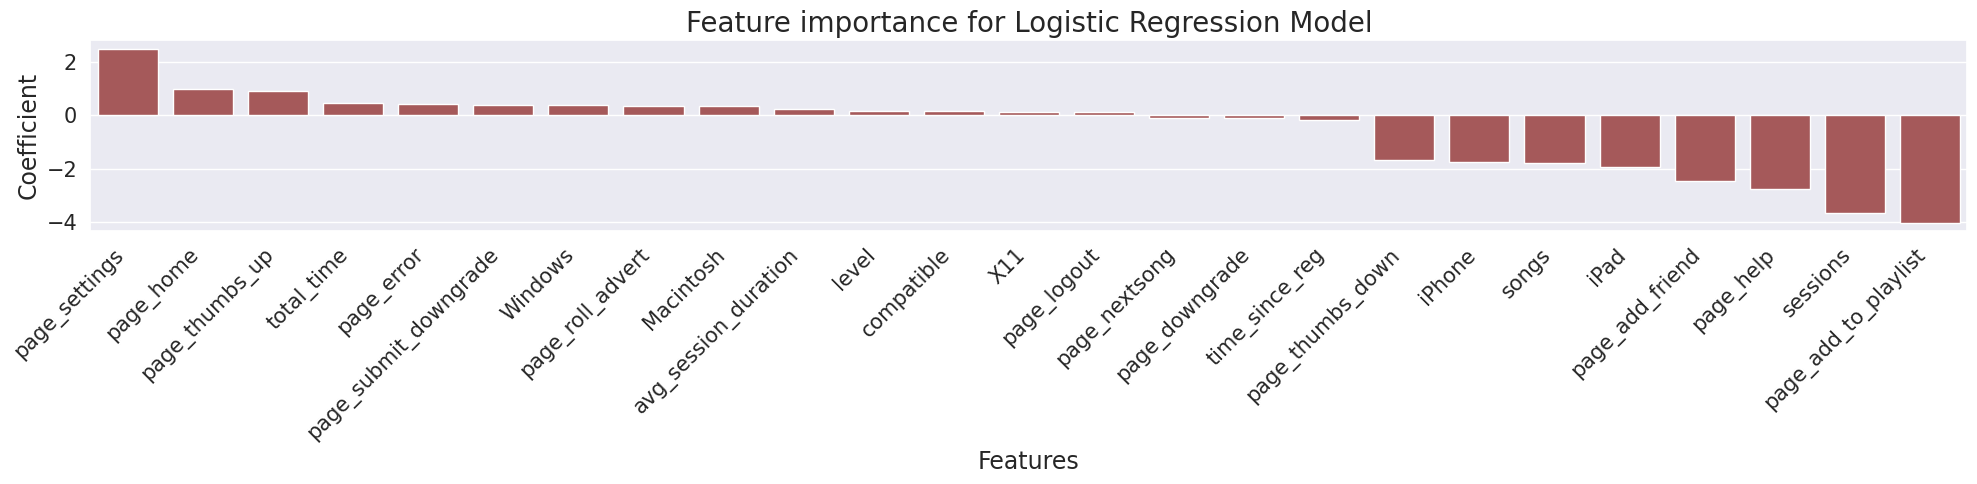

In [62]:
def plot_feature_importance(model, feature_cols):
    """
    Plot bar chart showing the importance of features with logistic regression model.
    """

    feature_coef = model.bestModel.stages[2].coefficients.values.tolist()
    feature_coef_df = pd.DataFrame(list(zip(feature_cols, feature_coef)), columns=['Feature', 'Coefficient'])\
    .sort_values('Coefficient', ascending=False)

    plt.figure(figsize=(20,5))
    sns.barplot(x='Feature', y='Coefficient', data=feature_coef_df)
    plt.title('Feature importance for Logistic Regression Model', fontsize=20)
    plt.xlabel('Features', fontsize=17)
    plt.ylabel('Coefficient', fontsize=17)
    plt.xticks(rotation=45, ha='right', fontsize=15)
    plt.yticks(fontsize=15)
    plt.tight_layout()
    plt.show()

plot_feature_importance(fit_model_tuned, user_df.columns[2:])

### Random Forest Tuning

In [63]:
rf = RandomForestClassifier(featuresCol="scaled_features", labelCol="churn")
paramGrid_rf = ParamGridBuilder()\
    .addGrid(rf.impurity,['entropy', 'gini']) \
    .addGrid(rf.maxDepth,[2, 4, 6, 8]) \
    .build()
model_tuned_rf = model_pipeline(rf, paramGrid_rf)

In [64]:
fit_model_tuned_rf = model_tuned_rf.fit(train)
best_model = fit_model_tuned_rf.bestModel
best_model_pred = best_model.transform(test)

In [65]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="churn")
best_f1_score = evaluator.evaluate(best_model_pred, {evaluator.metricName: "f1"})
best_accuracy_score = evaluator.evaluate(best_model_pred, {evaluator.metricName: "accuracy"})

print("f1 using tuned RF: {}".format(best_f1_score))
print("accuracy using tuned RF: {}".format(best_accuracy_score))

f1 using tuned RF: 0.977295995182174
accuracy using tuned RF: 0.9777777777777777


### Gradient Boost Tuning

In [66]:
gbt = GBTClassifier(featuresCol="scaled_features", labelCol="churn")
paramGrid_gbt = ParamGridBuilder()\
    .addGrid(gbt.maxDepth, [2, 4, 6, 8, 10]) \
    .build()
model_tuned_gbt = model_pipeline(gbt, paramGrid_gbt)

In [67]:
fit_model_tuned_gbt = model_tuned_gbt.fit(train)
best_model = fit_model_tuned_gbt.bestModel
best_model_pred = best_model.transform(test)

In [68]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="churn")
best_f1_score = evaluator.evaluate(best_model_pred, {evaluator.metricName: "f1"})
best_accuracy_score = evaluator.evaluate(best_model_pred, {evaluator.metricName: "accuracy"})

print("f1 using tuned RF: {}".format(best_f1_score))
print("accuracy using tuned RF: {}".format(best_accuracy_score))

f1 using tuned RF: 0.9966629214160665
accuracy using tuned RF: 0.9966666666666667


###  Decision Tree Tuning

In [69]:
dt = DecisionTreeClassifier(featuresCol="scaled_features", labelCol="churn")
paramGrid_dt = ParamGridBuilder()\
    .addGrid(dt.impurity,['entropy', 'gini']) \
    .addGrid(dt.maxDepth,[2, 4, 6, 8]) \
    .build()
model_tuned_dt = model_pipeline(dt, paramGrid_dt)

In [70]:
fit_model_tuned_dt = model_tuned_dt.fit(train)
best_model = fit_model_tuned_dt.bestModel
best_model_pred = best_model.transform(test)

In [71]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="churn")
best_f1_score = evaluator.evaluate(best_model_pred, {evaluator.metricName: "f1"})
best_accuracy_score = evaluator.evaluate(best_model_pred, {evaluator.metricName: "accuracy"})

print("f1 using tuned RF: {}".format(best_f1_score))
print("accuracy using tuned RF: {}".format(best_accuracy_score))

f1 using tuned RF: 0.9842251082251082
accuracy using tuned RF: 0.9844444444444445


Storing in ORC format

In [72]:
# Define the storage paths
parquet_path = "path_to_store_data/parquet_output"
orc_path = "path_to_store_data/orc_output"

# Save DataFrame as Parquet
df.write.mode("overwrite").parquet(parquet_path)

# Save DataFrame as ORC
df.write.mode("overwrite").orc(orc_path)

print("Data successfully saved in Parquet and ORC formats!")


Data successfully saved in Parquet and ORC formats!
